In [1]:
import os
import sys
from data.usc.folds import get_fold
from data.usc.features import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm
% matplotlib inline
import pylab

In [2]:
def get_data(feature_dir, fold_idx_list):
    X = []
    y = []
    file_idxs = []
    filenames = []

    for fold_idx in fold_idx_list:
        fold_data = get_fold(feature_dir, fold_idx, augment=True)

        X.append(fold_data['features'])
        y.append(fold_data['labels'])
        idxs = fold_data['file_idxs']

        if len(file_idxs) > 0:
            idxs = idxs + file_idxs[-1][-1, -1]
        file_idxs.append(idxs)

        filenames += fold_data['filenames']

    X = np.vstack(X)
    y = np.concatenate(y)
    file_idxs = np.vstack(file_idxs)

    return {'features': X, 'labels': y, 'file_idxs': file_idxs,
            'filenames': filenames}

In [3]:
def preprocess_data(viz_data, feature_mode='framewise', non_overlap=False,
                    non_overlap_chunk_size=10, use_min_max=False):
    
    # NOTE: This function mutates data so there aren't extra copies

    # Remove overlapping frames if no overlap
    if non_overlap:
        remove_data_overlap(viz_data, chunk_size=non_overlap_chunk_size)

    # Apply min max scaling to data
    min_max_scaler = MinMaxScaler()
    if use_min_max:
        train_data['features'] = min_max_scaler.fit_transform(viz_data['features'])

    if feature_mode == 'framewise':
        # Expand the labels to apply to each frame
        expand_framewise_labels(viz_data)
        
    elif feature_mode == 'stats':
        # Summarize frames in each file using summary statistics
        framewise_to_stats(viz_data)
        
    else:
        raise ValueError('Invalid feature mode: {}'.format(feature_mode))

    # Standardize features
    stdizer = StandardScaler()
    viz_data['features'] = stdizer.fit_transform(viz_data['features'])


    # Shuffle training data
    num_data_examples = len(viz_data['labels'])
    shuffle_idxs = np.random.permutation(num_data_examples)
    reverse_shuffle_idxs = np.argsort(shuffle_idxs)
    viz_data['features'] = viz_data['features'][shuffle_idxs]
    viz_data['labels'] = viz_data['labels'][shuffle_idxs]
    viz_data['file_idxs'] = [reverse_shuffle_idxs[slice(*pair)] \
                            for pair in viz_data['file_idxs']]

    return min_max_scaler, stdizer

In [4]:
def show_viz(trans_data, labels, title):
    cm = plt.cm.get_cmap('tab20c')
    cm_lst = [cm.colors[i] for i in range(num_classes)]
    
    plt.figure(figsize=(10, 8))    
    plt.title(title)
    x = []
    y = []
    for value in trans_data:
        x.append(value[0])
        y.append(value[1])
   
    for i in range(len(trans_data)):
        plt.scatter(x[i],y[i], c=cm_lst[labels[i]])
        plt.annotate(labels[i], alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                     textcoords='offset points', ha='right', va='bottom', size=7)
    if show:
        plt.show()

In [5]:
def show_viz_subplots(trans_data, labels, title, ax=None, show=True):
    cm = plt.cm.get_cmap('tab20c')
    cm_lst = [cm.colors[i] for i in range(num_classes)]
        
    ax.set_title(title)
    x = []
    y = []
    for value in trans_data:
        x.append(value[0])
        y.append(value[1])
   
    for i in range(len(trans_data)):
        ax.scatter(x[i],y[i], c=cm_lst[labels[i]])
        ax.annotate(labels[i], alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                     textcoords='offset points', ha='right', va='bottom', size=7)
    if show:
        #plt.subplots_adjust(wspace=0.1, hspace=0.1)
        plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
        plt.show()

In [6]:
num_classes=10
features_dir='/scratch/sk7898/embeddings/features/us8k/l3/reduced_input/original_48000_256_252_2048'
feature_mode='framewise'
non_overlap=False
non_overlap_chunk_size=10
use_min_max=False
fold_idx_list = [0]

#Loading data for dimensionality reduction
viz_data = get_data(features_dir, fold_idx_list)

#Preprocessing data
min_max_scaler, stdizer = preprocess_data(viz_data, feature_mode=feature_mode,\
                                          non_overlap=non_overlap,\
                                          non_overlap_chunk_size=non_overlap_chunk_size,\
                                          use_min_max=use_min_max)

X = viz_data['features']
y = viz_data['labels']

In [15]:
batch_size=1024
data = X[:batch_size,:]
labels = y[:batch_size]
#data = X
#labels = y
#print(len(y))

/home/sk7898/miniconda3/envs/l3embedding-new-cpu/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 5 separate connected components using meta-embedding (experimental)
  n_components
/home/sk7898/miniconda3/envs/l3embedding-new-cpu/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 3 separate connected components using meta-embedding (experimental)
  n_components
/home/sk7898/miniconda3/envs/l3embedding-new-cpu/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


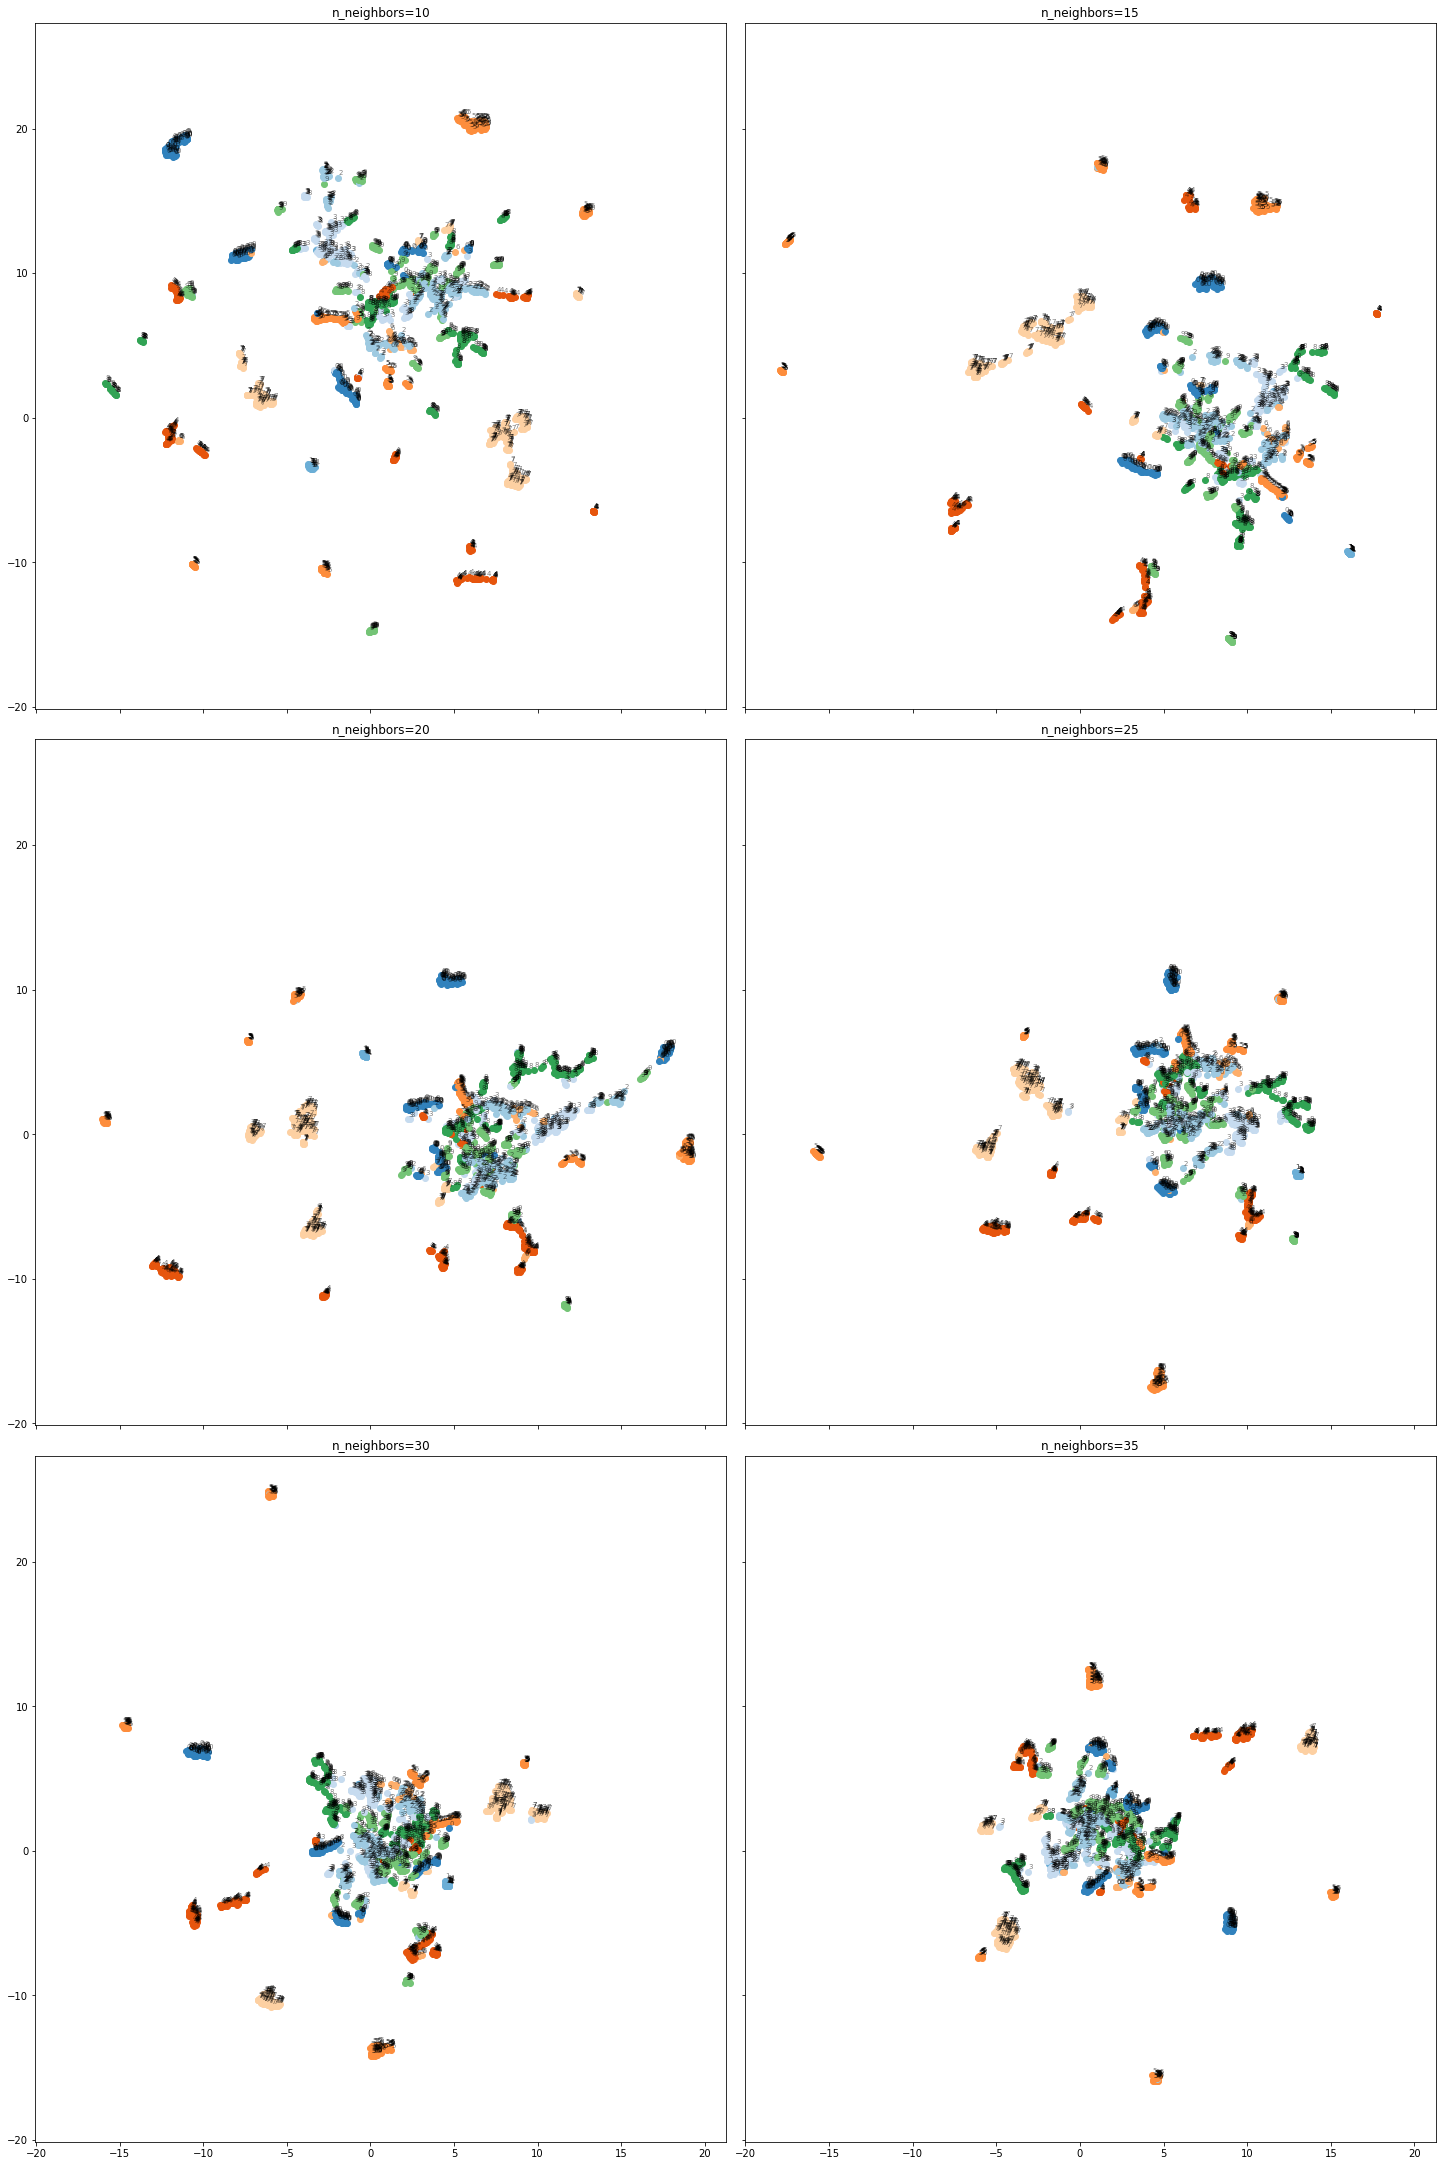

In [13]:
import umap

neighbor_list = [10, 15, 20, 25, 30, 35]
plt.close('all')
fig, axs = plt.subplots(3, 2, figsize=(20, 30), sharex=True, sharey=True)
axis = [axs[0, 0], axs[0, 1], axs[1, 0], axs[1, 1] , axs[2, 0], axs[2, 1]]
show = False

for i, neighbors in enumerate(neighbor_list):
    if i == len(neighbor_list)-1:
        show=True
    umap_data = umap.umap_.UMAP(n_neighbors=neighbors, min_dist=0.3, n_components=2).fit_transform(data)
    plt_title = 'n_neighbors='+str(neighbors)
    show_viz_subplots(umap_data, labels, plt_title, ax=axis[i], show=show)

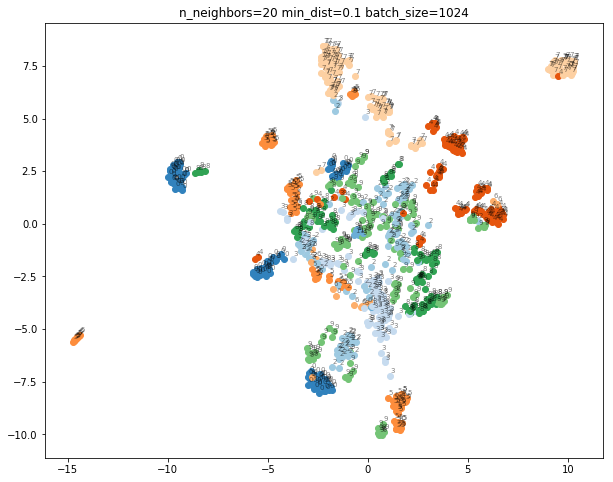

In [25]:
umap_data = umap.umap_.UMAP(n_neighbors=30, min_dist=0.5, n_components=2, metric='correlation').fit_transform(data)
plt_title = 'n_neighbors=20 min_dist=0.1 batch_size=1024'
show_viz(umap_data, labels, plt_title)

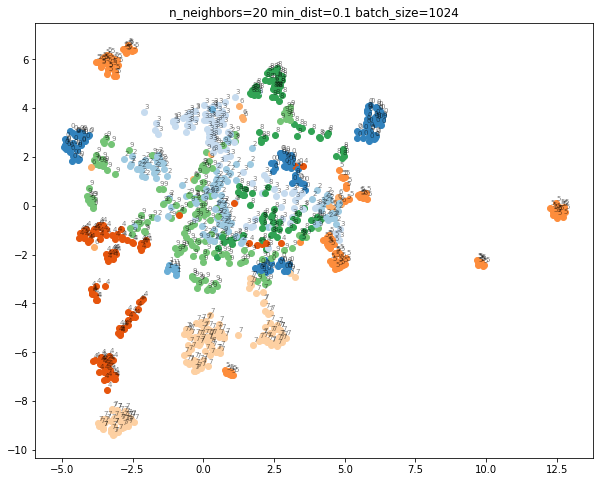

In [26]:
umap_data = umap.umap_.UMAP(n_neighbors=30, min_dist=0.5, n_components=2, metric='euclidean').fit_transform(data)
plt_title = 'n_neighbors=20 min_dist=0.1 batch_size=1024'
show_viz(umap_data, labels, plt_title)

In [ ]:
neighbor_list = [10, 20]
dist_list = [0.1, 0.2, 0.3, 0.5]
plt.close('all')
fig, axs = plt.subplots(3, 3, figsize=(30, 30), sharex=True, sharey=True)
axis = [axs[0, 0], axs[0, 1], axs[0, 2], axs[1, 0], axs[1, 1] , axs[1, 2], axs[2, 0], axs[2, 1], axs[2, 2]]
show = False

for i, neighbors in enumerate(neighbor_list):
    for j, dist in enumerate(dist_list):
        if i == len(neighbor_list)*len(dist_list)-1:
            show=True
        umap_data = umap.umap_.UMAP(n_neighbors=neighbors, min_dist=dist, n_components=2).fit_transform(data)
        plt_title = 'n_neighbors='+str(neighbors)
        show_viz_subplots(umap_data, labels, plt_title, ax=axis[i*len(min_dist) + j], show=show)

/home/sk7898/miniconda3/envs/l3embedding-new-cpu/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 46 separate connected components using meta-embedding (experimental)
  n_components
/home/sk7898/miniconda3/envs/l3embedding-new-cpu/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/sk7898/miniconda3/envs/l3embedding-new-cpu/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 42 separate connected components using meta-embedding (experimental)
  n_components
/home/sk7898/miniconda3/envs/l3embedding-new-cpu/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/sk7898

/home/sk7898/miniconda3/envs/l3embedding-new-cpu/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


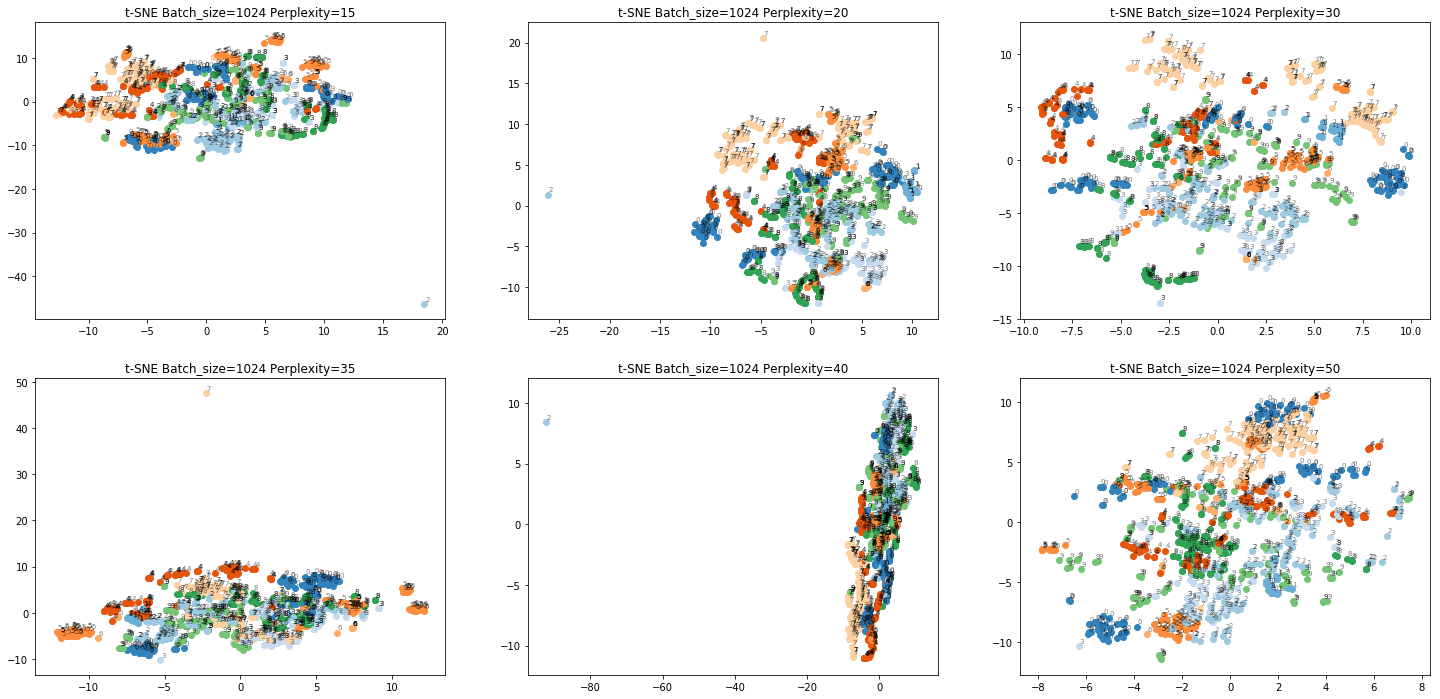

In [18]:
from sklearn.manifold import TSNE

#Effect of perplexities
perplexities = [15, 20, 30, 35, 40, 50]
plt.close('all')
fig1, axs1 = plt.subplots(2, 3, figsize=(25, 12), sharex=True, sharey=True)
axis1 = [axs1[0, 0], axs1[0, 1], axs1[0, 2], axs1[1, 0] , axs1[1, 1], axs1[1, 2]]
show = False

#Barnes-Hut Implementation
for i in range(len(perplexities)):
    if i == len(perplexities)-1:
        show=True
    trans_data = TSNE(perplexity=perplexities[i], n_components=3, n_iter=300).fit_transform(data)
    plt_title = 'Perplexity='+str(perplexities[i])
    show_viz_subplots(trans_data, labels, plt_title, ax=axis1[i], show=show)

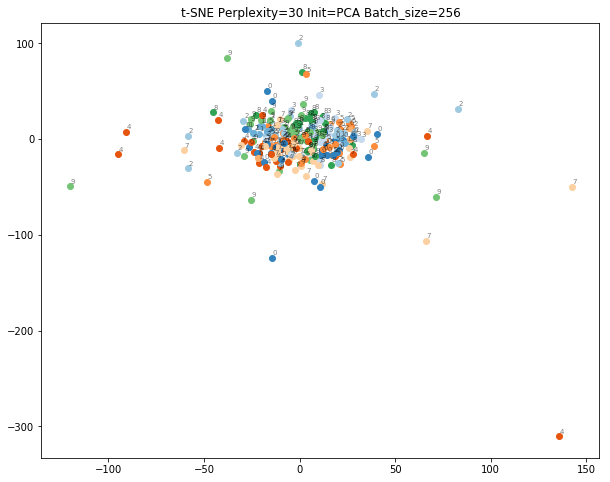

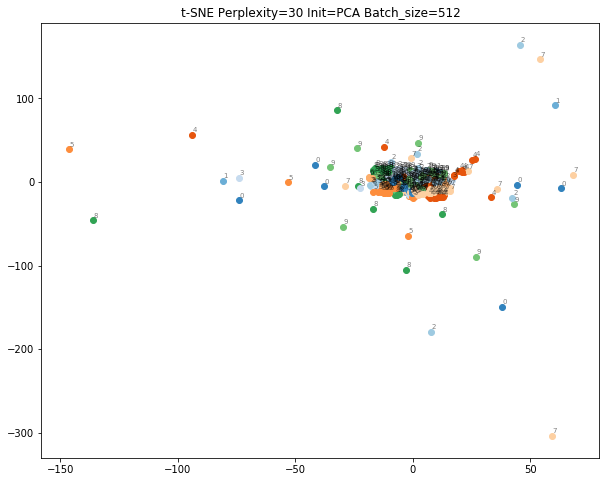

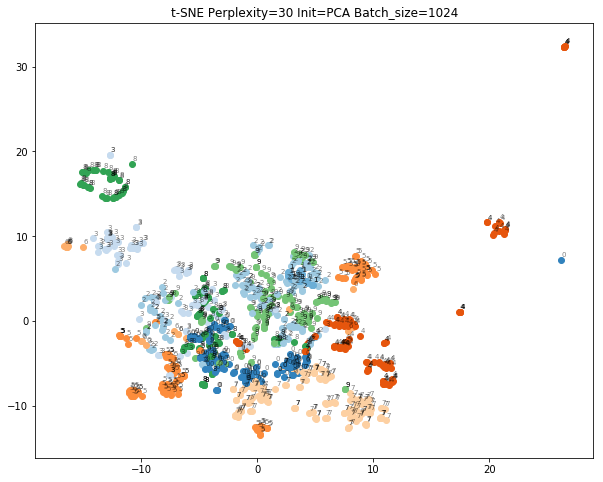

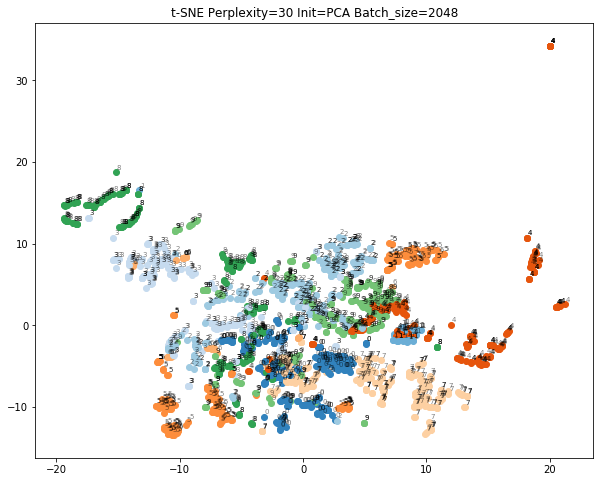

In [33]:
#Effect of batch size
batch_list = [256, 512, 1024, 2048]

for i, batch in enumerate(batch_list):
    batch_data = X[:batch,:]
    batch_labels = y[:batch]
    #if i == len(batch_list)-1:
    #    show=True
    tsne_data = TSNE(perplexity=30, n_components=3, init='pca', n_iter=300).fit_transform(batch_data)
    plt_title = 't-SNE Perplexity=30 Init=PCA Batch_size='+str(batch)
    show_viz(tsne_data, batch_labels, plt_title)
    #show_viz(tsne_data, batch_labels, plt_title, rows=2, cols=2, idx=i+1, fig=fig2, show=show)

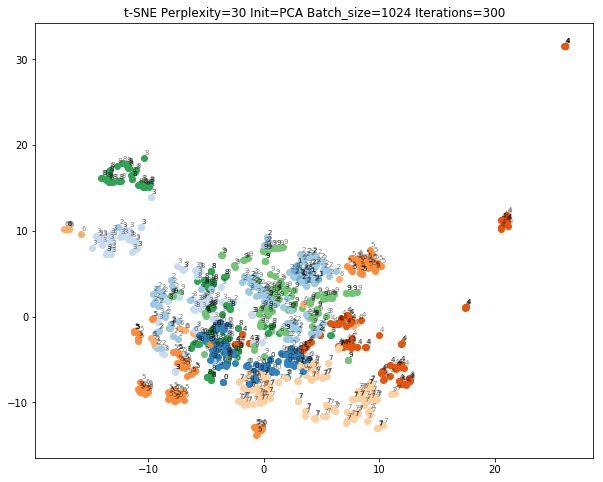

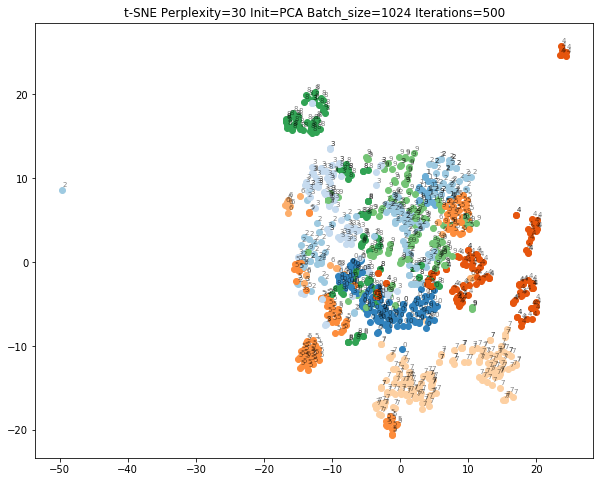

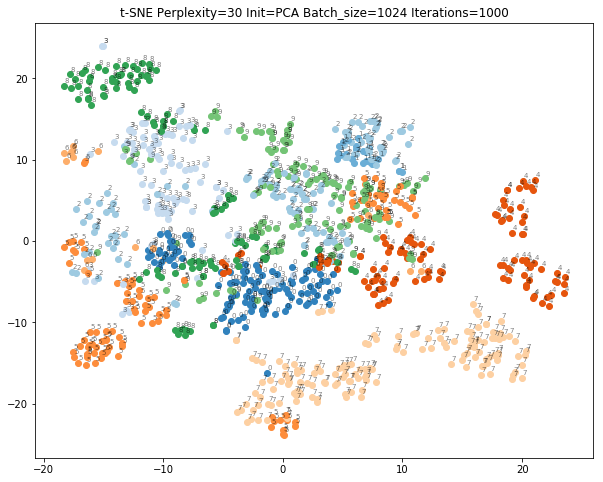

In [38]:
#Effect of iterations
iter_list = [300, 500, 1000]

for i, it in enumerate(iter_list):
    iter_data = TSNE(perplexity=30, n_components=3, init='pca', n_iter=it).fit_transform(data)
    plt_title = 't-SNE Perplexity=30 Init=PCA Batch_size=1024 Iterations='+str(it)
    show_viz(iter_data, labels, plt_title)

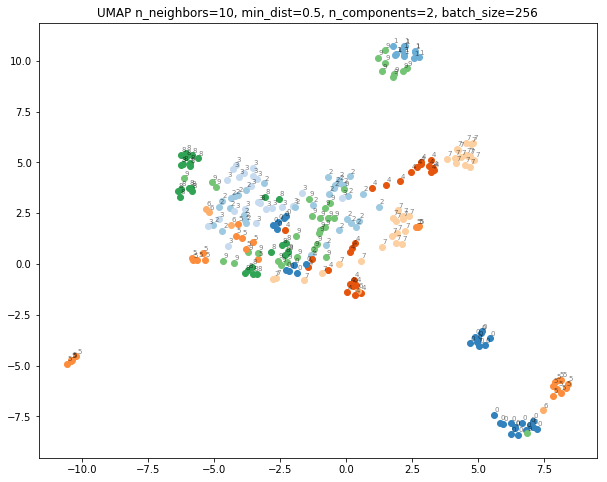

/home/sk7898/miniconda3/envs/l3embedding-new-cpu/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


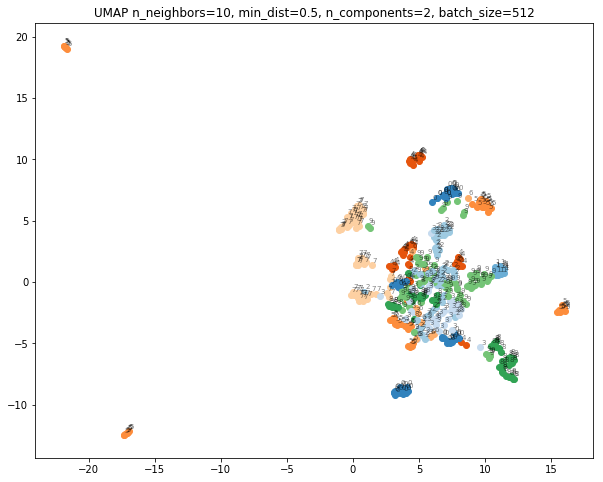

/home/sk7898/miniconda3/envs/l3embedding-new-cpu/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 3 separate connected components using meta-embedding (experimental)
  n_components


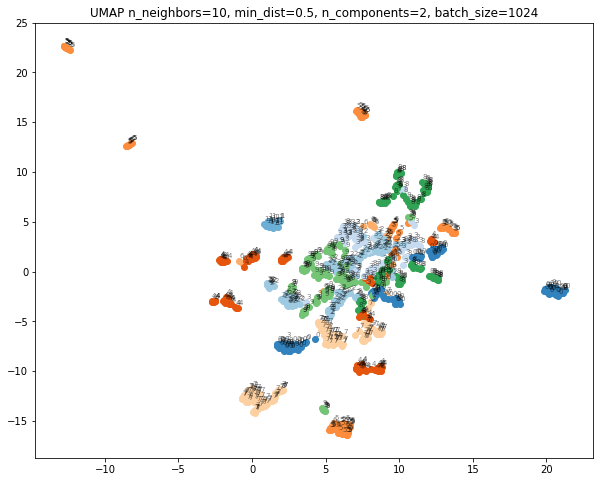

/home/sk7898/miniconda3/envs/l3embedding-new-cpu/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 7 separate connected components using meta-embedding (experimental)
  n_components


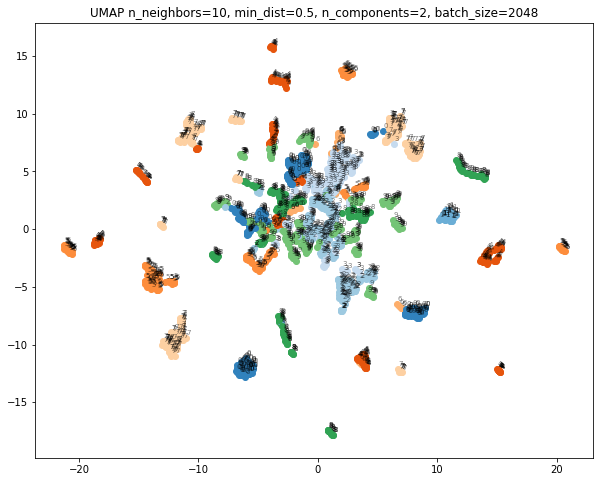

In [39]:
batch_list = [256, 512, 1024, 2048]

for i, batch in enumerate(batch_list):
    batch_data = X[:batch,:]
    batch_labels = y[:batch]
    umap_data = umap.umap_.UMAP(n_neighbors=10, min_dist=0.5, n_components=2).fit_transform(batch_data)
    plt_title = 'UMAP n_neighbors=10, min_dist=0.5, n_components=2, batch_size='+str(batch)
    show_viz(umap_data, batch_labels, plt_title)

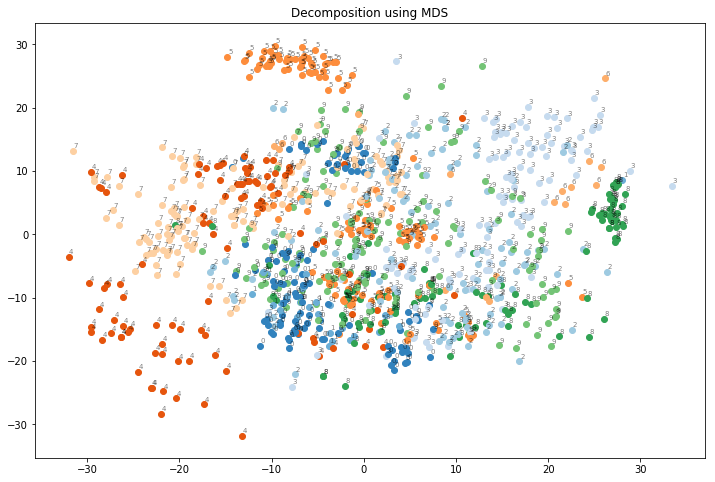

In [20]:
#Slower than barnes-hut t-SNE
from sklearn.manifold import MDS

embedding = MDS(n_components=3)
mds_data = embedding.fit_transform(data)
show_viz(mds_data, labels, 'Decomposition using MDS')